In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import sqlite3
import string
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

#NLP modules
import nltk
#preprocessing
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet
# for part-of-speech tagging
from nltk import pos_tag
# for named entity recognition (NER)
from nltk import ne_chunk
# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
#stop-words
stop_words=set(nltk.corpus.stopwords.words('english'))
import re # regex

#modeling part, model_selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
#evaluation
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve,scorer,auc
from sklearn.metrics import f1_score, average_precision_score
from sklearn.metrics import precision_score,recall_score, precision_recall_curve
from inspect import signature
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from pylab import rcParams

#data processing packages: preprocessing scikit
from sklearn.preprocessing import StandardScaler,Imputer,LabelEncoder
#classifiaction.
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.naive_bayes import MultinomialNB

#keras
import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence

#gensim w2v, word2vec
from gensim.models import Word2Vec

Using TensorFlow backend.


In [2]:
# using the SQLite Table to read data.
table = sqlite3.connect(r'database.sqlite')
#filtering only positive and negative reviews (not including Score=3) 
df = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", table) 
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [4]:
df1=df[['Text','Score','Summary']] #using "Summary" column for wordcloud later

In [5]:
df1.head()

,Text,Score,Summary
0,I have bought several of the Vitality canned d...,5,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,1,Not as Advertised
2,This is a confection that has been around a fe...,4,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,2,Cough Medicine
4,Great taffy at a great price. There was a wid...,5,Great taffy


In [6]:
df1.shape

(525814, 3)

In [7]:
# check for missing values
df1.isnull().sum()

Text       0
Score      0
Summary    0
dtype: int64

Note that there is no point for keeping rows with different scores or sentiment for same review text. So I will keep only one instance and drop the rest of the duplicates.

In [8]:
# remove duplicates and keep only one row for each duplicate. 
df1.drop_duplicates(subset=['Text','Score'],keep='first',inplace=True) 

In [9]:
df1.shape

(363903, 3)

In [10]:
for review in df1['Text'][:2]:
    print(review+'\n'+'\n')

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".




In [11]:
def mark_sentiment(score):
    if score < 3:
        return 0 #negative 
    else:
        return 1 #positve

In [12]:
df1['sentiment'] = df1['Score'].apply(mark_sentiment)
df1.head()

,Text,Score,Summary,sentiment
0,I have bought several of the Vitality canned d...,5,Good Quality Dog Food,1
1,Product arrived labeled as Jumbo Salted Peanut...,1,Not as Advertised,0
2,This is a confection that has been around a fe...,4,"""Delight"" says it all",1
3,If you are looking for the secret ingredient i...,2,Cough Medicine,0
4,Great taffy at a great price. There was a wid...,5,Great taffy,1


In [13]:
df1.drop(['Score'],axis=1,inplace=True)

In [14]:
df1.head()

,Text,Summary,sentiment
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,1
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,0
2,This is a confection that has been around a fe...,"""Delight"" says it all",1
3,If you are looking for the secret ingredient i...,Cough Medicine,0
4,Great taffy at a great price. There was a wid...,Great taffy,1


In [15]:
df1.sentiment.value_counts()

1    306819
0     57084
Name: sentiment, dtype: int64

In [16]:
df1.isnull().sum()

Text         0
Summary      0
sentiment    0
dtype: int64

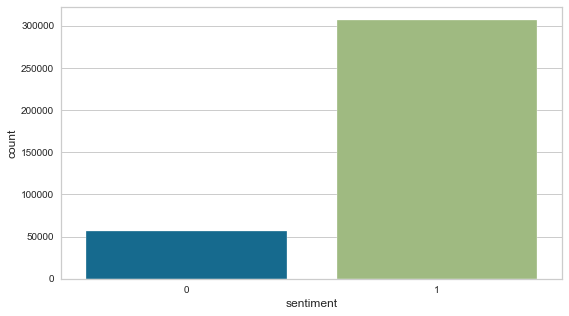

In [33]:
sentiment_count = df1.sentiment.value_counts()
plt.figure(figsize=(8,5))
sns.barplot(sentiment_count.index, sentiment_count.values)
plt.title('')
plt.ylabel('count', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.show()

Since it might be difficult to train with such huge data, I will reduce data size of 10000 rows for each sentiment class. To balance classes, I have selected equal samples from each class.

In [18]:
#train size: 20000 rows
pos_df = df1[df1.sentiment==1]
neg_df = df1[df1.sentiment==0]
train_pos_df=pos_df.sample(n=10000, random_state=42)
train_neg_df=neg_df.sample(n=10000, random_state=42)
train=pd.concat([train_pos_df, train_neg_df], axis=0)

In [19]:
#test size: 5000 rows in order to keep len(train):len(test)=4:1
test_pos_df = pos_df.loc[~pos_df.index.isin(train_pos_df.index)].sample(n=2500, random_state=42)
test_neg_df = neg_df.loc[~neg_df.index.isin(train_neg_df.index)].sample(n=2500, random_state=42)
test=pd.concat([test_pos_df, test_neg_df], axis=0)

In [20]:
train.shape

(20000, 3)

In [21]:
test.shape 

(5000, 3)

In [22]:
from sklearn.utils import shuffle

In [23]:
#Shuffle the dataframes so that the training is done in a random order.
train = shuffle(train)
test = shuffle(test)

In [24]:
train.head()

,Text,Summary,sentiment
231776,This is a Knock-off of k-cups. Never thought ...,knock-off,0
196000,Recieved the 1st bag and could tell as soon as...,Labled as Spearment but is Pepprement,0
387410,My two dogs showed absolutely no interest in t...,save your money,0
402979,Should have read the reviews before ordering. ...,Bergin Dates,0
177873,If you follow the directions (ahem) the beans ...,truly tasty,1


In [25]:
test.head()

,Text,Summary,sentiment
320785,"First, this tea smells like synthetic jasmine....",Those other good ratings are misleading,0
496320,i am not ordinarily a fan of mint/chocolate co...,if you must mix mint & chocolate... the perfec...,1
236502,I'm kind of addicted to pomegranates at the mo...,Not what I was hoping for...,0
378251,Why would a 12 pack of GoGo Squeez applesauce ...,Price?,0
425004,There is no flavor better than traditional bub...,A classic remains the best...,1


In [26]:
print(len(test[test.sentiment==1]))
print(len(test[test.sentiment==0]))

2500
2500


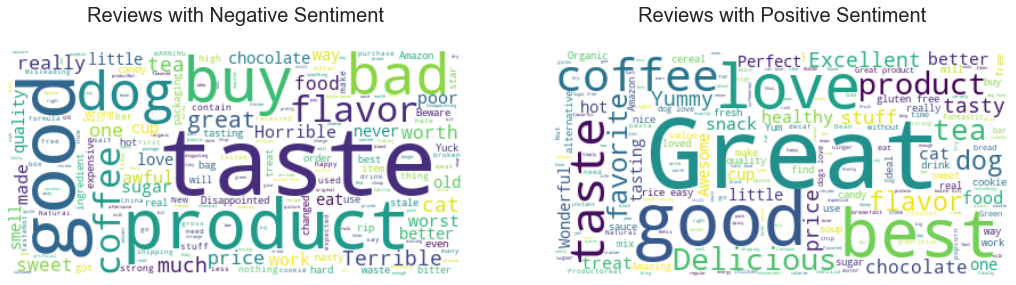

In [34]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
# Now let's split the data into Negative (Score is 1 or 2) and Positive (4 or 5) Reviews.
negative_reviews=train[train['sentiment']==0]
positive_reviews=train[train['sentiment']==1]

# Transform to single string
negative_reviews_str = negative_reviews.Summary.str.cat()
positive_reviews_str = positive_reviews.Summary.str.cat()

# Create wordclouds
wordcloud_negative = WordCloud(background_color='white').generate(negative_reviews_str)
wordcloud_positive = WordCloud(background_color='white').generate(positive_reviews_str)

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(121)
ax1.imshow(wordcloud_negative,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Reviews with Negative Sentiment\n',fontsize=20)

ax2 = fig.add_subplot(122)
ax2.imshow(wordcloud_positive,interpolation='bilinear')
ax2.axis("off")
ax2.set_title('Reviews with Positive Sentiment\n',fontsize=20)

plt.show()

In [28]:
#check stopwords
stop = set(stopwords.words('english')) 
print(stop)

{'over', 'your', 'a', 'you', 'or', 'not', 'because', "don't", 'be', 'shan', 'i', 'him', "you'd", 'on', 'do', 'above', "that'll", 'myself', 'yourself', 'been', 'into', 'hadn', 'theirs', 'yours', 'to', 'there', "she's", 'both', 'ain', 'here', 'during', "wasn't", 'me', 'and', 'am', "haven't", 'by', 'this', 'between', 'after', 'what', 'needn', 'once', "shouldn't", 'm', 'in', 't', "doesn't", 'some', 'does', "you'll", 'more', "mightn't", 'too', 'didn', 'no', 'herself', 'don', 'than', "you're", 'isn', 'our', 'mustn', "weren't", 'for', 'very', 'doesn', 'is', 'himself', 'how', 'shouldn', 'who', 'if', 'yourselves', 'his', 'off', 'below', 'themselves', "needn't", 'won', 'have', 'aren', 'where', 'we', "hadn't", "won't", 'with', 'those', "shan't", 'are', 'was', 'all', 'from', 'whom', 'will', 'couldn', "mustn't", 'doing', 'under', 'an', 'only', 'haven', 're', 'as', 'the', 'until', 'its', 'just', 'nor', 'ours', 'so', "didn't", 'd', 'being', 'other', 'them', 'through', 'can', 'ourselves', 'now', 'had'

In [29]:
# find sentences containing HTML tags
import re
i=0;
for sent in df1['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

10
I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!


In [35]:
#clean text for train dataset
train_text = train['Text']
temp =[]

for sentence in train_text:
    # 1.Removing HTML tags
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        
    # 2.Retaining only alphabets
    sentence = re.sub("[^a-zA-Z]"," ",sentence)
    # 3. Removing Punctuations
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence)      
    # 4. Converting to lowercase
    sentence = sentence.lower().split()                 
    # 5. Remove stopwords
    le=WordNetLemmatizer()
    stop_words= set(stopwords.words("english"))     
    word_tokens= [le.lemmatize(w) for w in sentence if not w in stop_words]
    
    temp.append(word_tokens)
    
train_text = temp    

In [36]:
train_text[1]

['recieved',
 'st',
 'bag',
 'could',
 'tell',
 'soon',
 'opened',
 'peppermint',
 'contacted',
 'right',
 'person',
 'sent',
 'another',
 'bag',
 'turned',
 'peppermint',
 'also',
 'gave']

In [37]:
from gensim.models import Word2Vec
#define training data
all_words = train_text
#train model
word2vec = Word2Vec(all_words, min_count=2)
#summarize the model
print(word2vec)

Word2Vec(vocab=14341, size=100, alpha=0.025)


In [38]:
vocabulary = word2vec.wv.vocab

In [39]:
#check first 3 items in the dictionary
iterator = iter(vocabulary.items())
for i in range(3):
    print(next(iterator))

('knock', <gensim.models.keyedvectors.Vocab object at 0x000001A955F7CEB8>)
('k', <gensim.models.keyedvectors.Vocab object at 0x000001A955F80898>)
('cup', <gensim.models.keyedvectors.Vocab object at 0x000001A955F80C50>)


In [40]:
v1 = word2vec.wv['like']
print(v1)

[-9.2218035e-01 -1.6777618e-01 -8.2799661e-01 -6.3227332e-01
  1.7982692e-01 -1.6592361e+00 -1.6439730e-01  4.7742194e-01
 -4.8027247e-01  8.4965008e-01 -4.8659778e-01 -4.7800425e-01
  6.2083278e-02 -1.2665752e+00 -2.1561557e-01 -7.5826168e-01
  6.8717927e-01  3.3972129e-01  4.6615258e-01 -8.2199842e-01
 -7.6482022e-01 -5.8007163e-01  1.1510386e+00  1.1518177e+00
  1.2021497e+00 -3.6319521e-01  4.8231846e-01 -9.9326742e-01
  1.3909046e-01 -2.4410421e-01  1.5614380e-01  3.5107467e-01
  5.1183689e-01 -1.0830832e-01 -1.0219427e+00 -3.4706542e-01
  2.2015243e+00 -2.7266774e-01  3.3246410e-01 -5.9748352e-01
 -4.8073736e-01 -6.6866183e-01  1.7207823e+00  1.1079441e+00
 -6.0721314e-01 -1.1791940e+00 -1.1852688e+00  5.1174271e-01
 -5.7580751e-01  1.7986357e-01 -2.7646419e-02  5.3764194e-01
  1.1759577e+00  2.3019226e-01  3.7574270e-01  2.7806690e-01
 -9.4439358e-01 -2.1136633e-01 -2.7513427e-01  5.0501865e-01
 -1.3915669e-03  3.3337837e-01  1.1186266e+00 -2.0248747e-01
  7.9665609e-02  8.75218

In [41]:
sim_words = word2vec.wv.most_similar('good')
sim_words

[('great', 0.8443644046783447),
 ('decent', 0.8411062955856323),
 ('amazing', 0.7565556168556213),
 ('breaker', 0.7321344017982483),
 ('beat', 0.722380518913269),
 ('similar', 0.7040066123008728),
 ('excellent', 0.703644871711731),
 ('terrific', 0.6960005760192871),
 ('awesome', 0.6940780878067017),
 ('fantastic', 0.6923593282699585)]

In [42]:
sim_words_1 = word2vec.wv.most_similar('tea')
sim_words_1

[('earl', 0.7956136465072632),
 ('green', 0.7933641672134399),
 ('mountain', 0.7865074872970581),
 ('grey', 0.7779464721679688),
 ('chai', 0.7751807570457458),
 ('twinings', 0.737809419631958),
 ('herbal', 0.7256506681442261),
 ('lipton', 0.7242178916931152),
 ('oolong', 0.7221772074699402),
 ('matcha', 0.7221481204032898)]

In [43]:
word2vec.wv.similarity('good','amazing')

0.75655556

In [44]:
word2vec.wv.similarity('tea','coffee')

0.57919014

In [45]:
vocab=word2vec.wv.vocab
print("The total number of words are : ",len(vocab))

The total number of words are :  14341


In [47]:
sent = []
for row in train_text:
    sequence = ''
    for word in row:
        sequence = sequence + ' ' + word
    sent.append(sequence)
train_text = sent

In [48]:
train['Cleaned_Text']=train_text
train.head()

,Text,Summary,sentiment,Cleaned_Text
231776,This is a Knock-off of k-cups. Never thought ...,knock-off,0,knock k cup never thought amazon would sell k...
196000,Recieved the 1st bag and could tell as soon as...,Labled as Spearment but is Pepprement,0,recieved st bag could tell soon opened pepper...
387410,My two dogs showed absolutely no interest in t...,save your money,0,two dog showed absolutely interest pee post t...
402979,Should have read the reviews before ordering. ...,Bergin Dates,0,read review ordering dry given another brand ...
177873,If you follow the directions (ahem) the beans ...,truly tasty,1,follow direction ahem bean get perfectly tend...


In [49]:
#clean text for test dataset
test_text = test['Text']
temp =[]

for sentence in test_text:
    
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)          # Removing HTML tags
    sentence = re.sub("[^a-zA-Z]"," ",sentence)       # Retaining only alphabets
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence) # Removing Punctuations
    
    sentence = sentence.lower().split()               # Converting to lowercase
                                       
    le=WordNetLemmatizer()                            # Remove stopwords
    stop_words= set(stopwords.words("english"))     
    word_tokens= [le.lemmatize(w) for w in sentence if not w in stop_words]
    
    temp.append(word_tokens)
    
test_text = temp    

In [50]:
sent = []
for row in test_text:
    sequence = ''
    for word in row:
        sequence = sequence + ' ' + word
    sent.append(sequence)
test_text = sent

In [51]:
test['Cleaned_Text']=test_text
test.head()

,Text,Summary,sentiment,Cleaned_Text
320785,"First, this tea smells like synthetic jasmine....",Those other good ratings are misleading,0,first tea smell like synthetic jasmine purely...
496320,i am not ordinarily a fan of mint/chocolate co...,if you must mix mint & chocolate... the perfec...,1,ordinarily fan mint chocolate combo usually t...
236502,I'm kind of addicted to pomegranates at the mo...,Not what I was hoping for...,0,kind addicted pomegranate moment saw product ...
378251,Why would a 12 pack of GoGo Squeez applesauce ...,Price?,0,would pack gogo squeez applesauce almost get ...
425004,There is no flavor better than traditional bub...,A classic remains the best...,1,flavor better traditional bubble gum gum worl...


#### Topic Modeling LDA

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.8, min_df=2)
doc_term_matrix = count_vect.fit_transform(train['Cleaned_Text'].values.astype('U'))

In [53]:
# our vocabulary has 13498 words.
doc_term_matrix

<20000x13498 sparse matrix of type '<class 'numpy.int64'>'
	with 651602 stored elements in Compressed Sparse Row format>

In [54]:
from sklearn.decomposition import LatentDirichletAllocation
#n_components:number of categories/topics that we want our text to be divided into. 
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [55]:
# randomly fetches 10 words from our vocabulary:
import random

for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])

lundberg
favored
folk
drugstore
wire
shes
effectively
spritzer
kid
scarring


In [56]:
#find 10 words with the highest probability for the first topic. 
first_topic = LDA.components_[0]

In [57]:
top_topic_words = first_topic.argsort()[-10:]

In [58]:
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

sweet
good
one
water
sugar
drink
flavor
like
taste
tea


In [59]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['sweet', 'good', 'one', 'water', 'sugar', 'drink', 'flavor', 'like', 'taste', 'tea']


Top 10 words for topic #1:
['good', 'buy', 'product', 'box', 'one', 'chocolate', 'store', 'bag', 'price', 'amazon']


Top 10 words for topic #2:
['ingredient', 'love', 'eat', 'like', 'one', 'product', 'treat', 'cat', 'dog', 'food']


Top 10 words for topic #3:
['item', 'ordered', 'get', 'box', 'amazon', 'order', 'time', 'one', 'would', 'product']


Top 10 words for topic #4:
['product', 'great', 'one', 'make', 'cup', 'good', 'flavor', 'like', 'taste', 'coffee']




In [60]:
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(20000, 5)

In the output, (20000, 5) means that each of the document has 5 columns where each column corresponds to the probability value of a particular topic. To find the topic index with maximum value, we can call the argmax() method and pass 1 as the value for the axis parameter.

In [62]:
train['Topic']=topic_values.argmax(axis=1)
train.head()

,Text,Summary,sentiment,Cleaned_Text,Topic
231776,This is a Knock-off of k-cups. Never thought ...,knock-off,0,knock k cup never thought amazon would sell k...,4
196000,Recieved the 1st bag and could tell as soon as...,Labled as Spearment but is Pepprement,0,recieved st bag could tell soon opened pepper...,3
387410,My two dogs showed absolutely no interest in t...,save your money,0,two dog showed absolutely interest pee post t...,2
402979,Should have read the reviews before ordering. ...,Bergin Dates,0,read review ordering dry given another brand ...,1
177873,If you follow the directions (ahem) the beans ...,truly tasty,1,follow direction ahem bean get perfectly tend...,4


In [63]:
#put confusion matrix, classification report, roc curve and PR curve together
def model_performance(algorithm,X_training,X_testing,y_training,y_testing):
    
    algorithm.fit(X_training, y_training)
    predictions = algorithm.predict(X_testing)
    probas = algorithm.predict_proba(X_testing)
    print(algorithm)
    print("Accuracy Score : ", accuracy_score(y_testing,predictions))
    print("Recall Score :", recall_score(y_testing,predictions))
    print("Precision Score :", precision_score(y_testing,predictions))
    print("F1 Score :", f1_score(y_testing,predictions))                               
    print ("AUC Score : ",roc_auc_score(y_testing,probas[:,1]) ,"\n")
    fpr,tpr,thresholds = roc_curve(y_testing,probas[:,1])
    #compute average precision and area under precision-recall curve
    average_precision = average_precision_score(y_testing, probas[:,1])
    precision, recall, t = precision_recall_curve(y_testing, probas[:,1])
    area = auc(recall, precision)
    #confusion matrix
    conf_matrix = confusion_matrix(y_testing, predictions)
    
    
    rcParams['figure.figsize'] = 12, 10
    fig, axs = plt.subplots(2, 2)
    
    #plot roc curve
    plt.subplot(2, 2, 1)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label='recall_optimized')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
   
    #plot confusion matrix 
    plt.subplot(2, 2, 2)
    sns.heatmap(conf_matrix, annot = True, linewidths = 0.5, color = "red", fmt = ".0f")
    plt.xlabel("y_predicted")
    plt.ylabel("y_true")
    plt.title("Confusion Matrix")
    
    #plot precision recall curve
    plt.subplot(2, 2, 3)
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    plt.step(recall, precision, color='b', alpha=0.2,where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: \n Average Precision-Recall Score={0:0.2f}'.format(
          average_precision))
    
    #plot classification report
    plt.subplot(2, 2, 4)
    classes = ["negative","positive"]
    visualizer = ClassificationReport(algorithm, classes=classes, support=True)

    visualizer.fit(X_training, y_training)  # Fit the visualizer and the model
    visualizer.score(X_testing, y_testing)  # Evaluate the model on the test data
    g = visualizer.poof() 
    
    plt.show()

In [64]:
#SVM classifier doesn't have predict_proba function,so I create separate visualization fucntion below
def SVM_model_performance(algorithm,X_training,X_testing,y_training,y_testing):
    
    algorithm.fit(X_training, y_training)
    predictions = algorithm.predict(X_testing)
    print(algorithm)
    print("Accuracy Score : ", accuracy_score(y_testing,predictions))
    print("Recall Score :", recall_score(y_testing,predictions))
    print("Precision Score :", precision_score(y_testing,predictions))
    print("F1 Score :", f1_score(y_testing,predictions))                               
    #confusion matrix
    cm = confusion_matrix(y_testing, predictions)
    
    rcParams['figure.figsize'] = 12, 5
    fig, axs = plt.subplots(1, 2)
   
    #plot confusion matrix 
    plt.subplot(1, 2, 1)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusiion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    
    #plot classification report
    plt.subplot(1, 2, 2)
    classes = ["negative","positive"]
    visualizer = ClassificationReport(algorithm, classes=classes, support=True)
    visualizer.fit(X_training, y_training)  # Fit the visualizer and the model
    visualizer.score(X_testing, y_testing)  # Evaluate the model on the test data
    g = visualizer.poof() 
    
    plt.show()

### N-grams

In [65]:
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit(train['Cleaned_Text'].values)
X_ngram = ngram_vectorizer.transform(train['Cleaned_Text'].values)
X_test_ngram = ngram_vectorizer.transform(test['Cleaned_Text'].values)
y_ngram = train['sentiment'].values
y_test_ngram = test['sentiment'].values

#### Logistic Regression

In [66]:
# Logistic Regression 
from sklearn.linear_model import LogisticRegression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_ngram,y_ngram)

best_log_reg = grid_log_reg.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy Score :  0.8762
Recall Score : 0.8828
Precision Score : 0.8712988551125148
F1 Score : 0.8770117226306378
AUC Score :  0.9459008000000001 



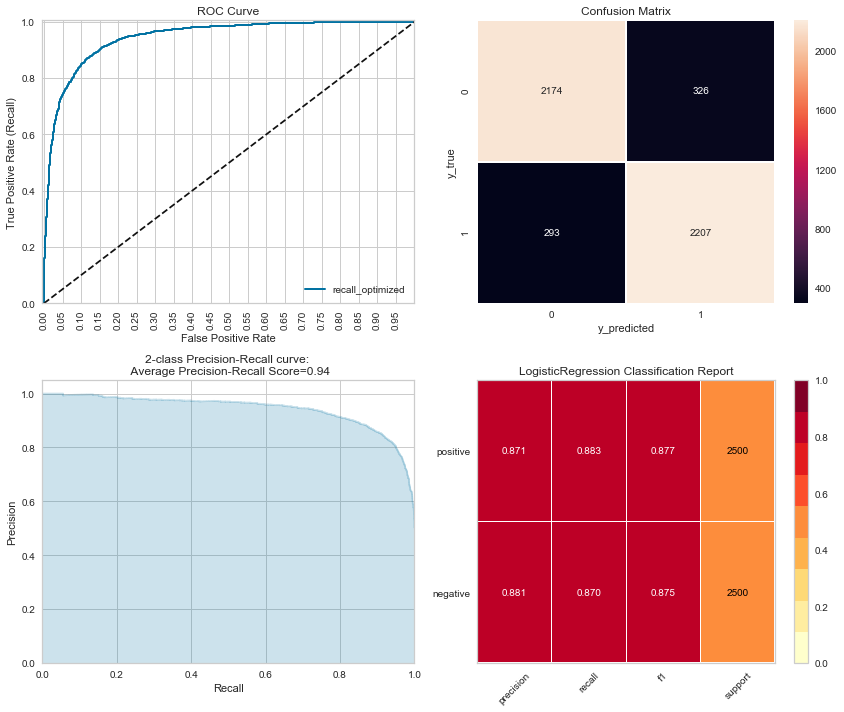

In [67]:
model_performance(best_log_reg, X_ngram, X_test_ngram, y_ngram, y_test_ngram)

In [68]:
#sanity check, 5 most discriminating words for both positive and negative reviews. 
feature_to_coef = {
    word: coef for word, coef in zip(
        ngram_vectorizer.get_feature_names(), best_log_reg.coef_[0])
}
print("Postive reviews:\n")
for best_positive in sorted(feature_to_coef.items(), 
    key=lambda x: x[1], reverse=True)[:5]:
    print(best_positive)
print("\n")
print("Negative reviews:\n")   
for best_negative in sorted(feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print(best_negative)

Postive reviews:

('delicious', 2.3114741255464364)
('perfect', 2.052533352903719)
('best', 1.9612507598098108)
('excellent', 1.9312605145769315)
('great', 1.893025920427535)


Negative reviews:

('worst', -2.392350968003095)
('disappointing', -1.922019162381999)
('horrible', -1.8792019995638232)
('awful', -1.8605162589757662)
('disappointed', -1.8477975929070918)


#### Naive Bayes

In [69]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
scalar.fit(X_ngram)
X_ngram_NB = scalar.transform(X_ngram)
X_test_ngram_NB = scalar.transform(X_test_ngram)

In [70]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

parameters = {"alpha":  np.array( [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10] )}
    
model = MultinomialNB()
    
grid_NB = GridSearchCV(estimator=model, param_grid=parameters, cv=10,scoring='f1')

grid_NB.fit(X_ngram_NB, y_ngram)

best_NB = grid_NB.best_estimator_

MultinomialNB(alpha=10.0, class_prior=None, fit_prior=True)
Accuracy Score :  0.7718
Recall Score : 0.7872
Precision Score : 0.7636786961583236
F1 Score : 0.7752609808942289
AUC Score :  0.80993056 



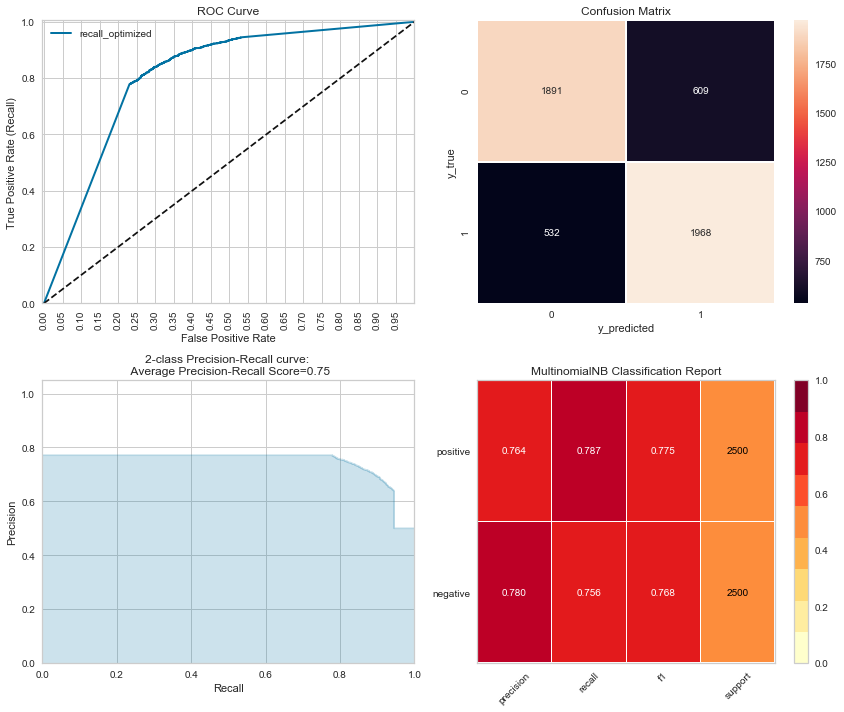

In [71]:
model_performance(best_NB, X_ngram_NB, X_test_ngram_NB, y_ngram, y_test_ngram)

#### LinearSVC

In [73]:
from sklearn.pipeline import Pipeline
SVCpipe = Pipeline([('scale', StandardScaler(with_mean = False)),
                   ('SVC',LinearSVC())])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.array([0.001, 0.005, 0.01, 0.05, 0.1])}
grid_linearSVC = GridSearchCV(SVCpipe,param_grid,cv=10,return_train_score=True)
grid_linearSVC.fit(X_ngram, y_ngram)
print(grid_linearSVC.best_params_)
best_linearSVC = grid_linearSVC.best_estimator_

{'SVC__C': 0.001}


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('SVC',
                 LinearSVC(C=0.001, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)
Accuracy Score :  0.8472
Recall Score : 0.8864
Precision Score : 0.8219584569732937
F1 Score : 0.852963818321786


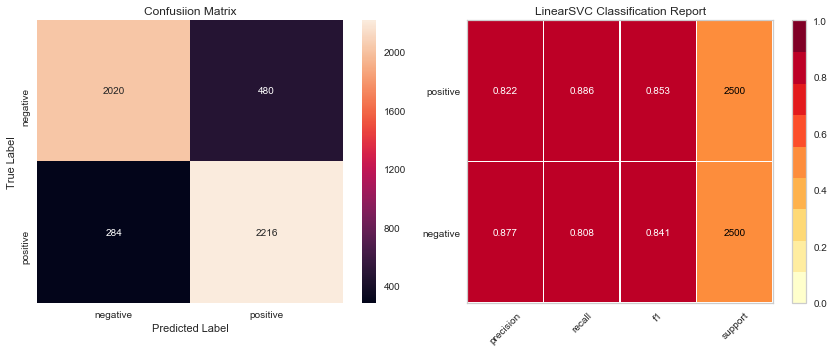

In [74]:
SVM_model_performance(best_linearSVC, X_ngram, X_test_ngram, y_ngram, y_test_ngram)

### TF-IDF

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(train['Cleaned_Text'].values)
X_tfidf = tfidf_vectorizer.transform(train['Cleaned_Text'].values)
X_test_tfidf = tfidf_vectorizer.transform(test['Cleaned_Text'].values)
y_tfidf = train['sentiment'].values
y_test_tfidf = test['sentiment'].values

#### Logistic Regression

In [76]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_tfidf, y_tfidf)

best_log_reg = grid_log_reg.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy Score :  0.867
Recall Score : 0.8752
Precision Score : 0.8610783156237701
F1 Score : 0.8680817298155127
AUC Score :  0.94153248 



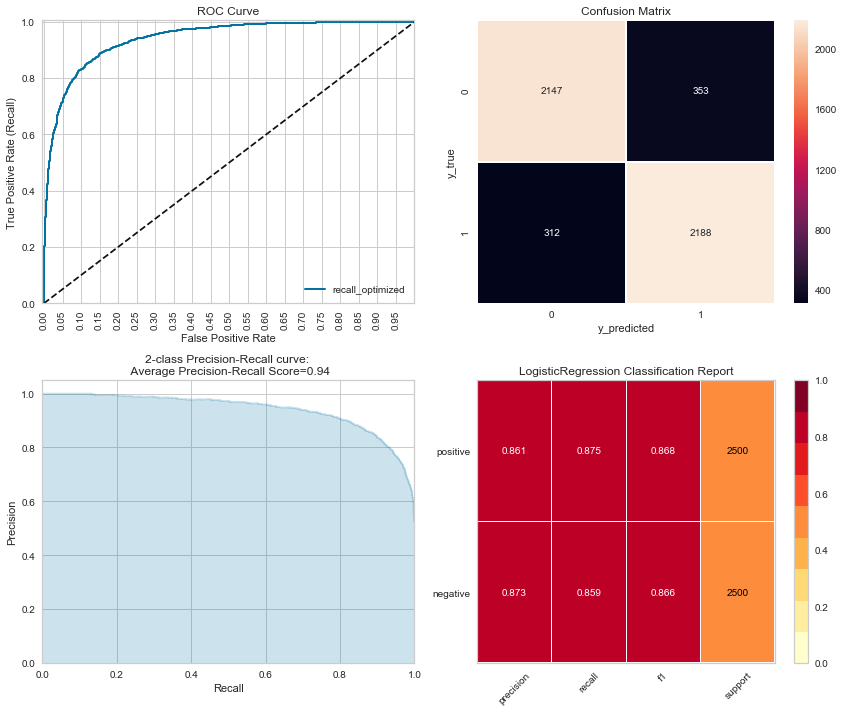

In [77]:
model_performance(best_log_reg, X_tfidf, X_test_tfidf, y_tfidf, y_test_tfidf)

#### Naive Bayes

In [78]:
#Colum Standardization of the TFIDF vector 
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler(with_mean=False)
scalar.fit(X_tfidf)
X_tfidf_NB = scalar.transform(X_tfidf)
X_test_tfidf_NB = scalar.transform(X_test_tfidf)

In [79]:
parameters = {"alpha":  np.array( [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10] )}
model = MultinomialNB()   
grid_NB = GridSearchCV(estimator=model, param_grid=parameters, cv=10, scoring='f1')
grid_NB.fit(X_tfidf_NB, y_tfidf)
best_NB = grid_NB.best_estimator_

MultinomialNB(alpha=10.0, class_prior=None, fit_prior=True)
Accuracy Score :  0.7468
Recall Score : 0.7676
Precision Score : 0.7369431643625192
F1 Score : 0.7519592476489028
AUC Score :  0.76224616 



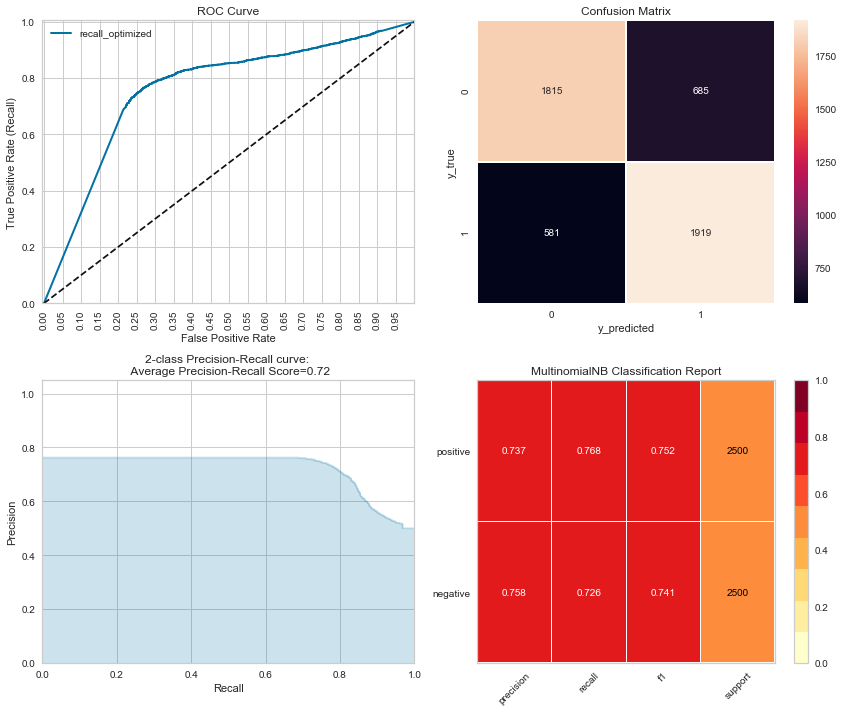

In [80]:
model_performance(best_NB, X_tfidf_NB, X_test_tfidf_NB, y_tfidf, y_test_tfidf)

#### LinearSVC

In [81]:
SVCpipe = Pipeline([('scale', StandardScaler(with_mean = False)),
                   ('SVC',LinearSVC())])

# Gridsearch to determine the value of C
param_grid = {'SVC__C':np.array([0.001, 0.005, 0.01, 0.05, 0.1])}
grid_linearSVC = GridSearchCV(SVCpipe,param_grid,cv=10,return_train_score=True)
grid_linearSVC.fit(X_tfidf, y_tfidf)
print(grid_linearSVC.best_params_)
best_linearSVC = grid_linearSVC.best_estimator_

{'SVC__C': 0.001}


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('SVC',
                 LinearSVC(C=0.001, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)
Accuracy Score :  0.8012
Recall Score : 0.8116
Precision Score : 0.7950626959247649
F1 Score : 0.8032462391132223


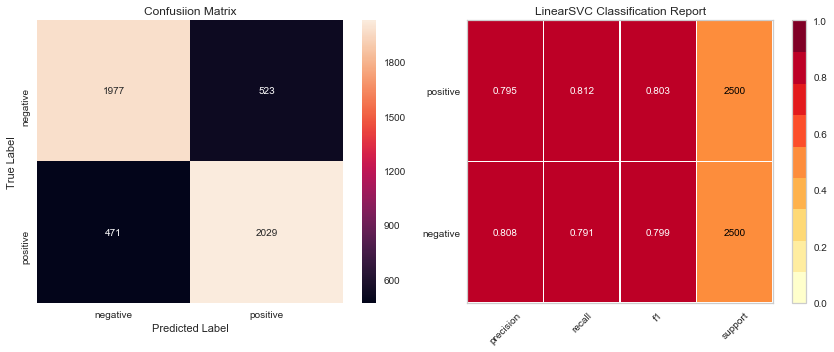

In [82]:
SVM_model_performance(best_linearSVC, X_tfidf, X_test_tfidf, y_tfidf, y_test_tfidf)

In [83]:
#sanity check, 5 most discriminating words for both positive and negative reviews. 
feature_to_coef = {
    word: coef for word, coef in zip(
        tfidf_vectorizer.get_feature_names(), best_log_reg.coef_[0])
}
print("Postive reviews:\n")
for best_positive in sorted(feature_to_coef.items(), 
    key=lambda x: x[1], reverse=True)[:5]:
    print(best_positive)
print("\n")
print("Negative reviews:\n")   
for best_negative in sorted(feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print(best_negative)

Postive reviews:

('great', 9.475661912403726)
('delicious', 7.149362189765748)
('best', 7.0465580997114285)
('love', 6.894588340852909)
('perfect', 5.823017376831762)


Negative reviews:

('disappointed', -5.9390452782726815)
('worst', -4.973928722172328)
('awful', -4.408899102158909)
('horrible', -4.30330689999556)
('terrible', -4.222676810801303)


In [84]:
#preparing the Embedding Layer 
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train['Cleaned_Text'])

X_train = tokenizer.texts_to_sequences(train['Cleaned_Text'])
X_test = tokenizer.texts_to_sequences(test['Cleaned_Text'])

We set the maximum size of each list to 100. You can try a differnt size. The lists with size greater than 100 will be truncated to 100. For the lists that have length less than 100, we will add 0 at the end of the list until it reaches the max length. This process is called padding.

In [85]:
#finds the vocabulary size and then perform padding on both train and test set.
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [86]:
#corpus has 24764 unique words.
embed_size = 100
window_size = 2 # context window size
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(tokenizer.word_index.items())[:10])

Vocabulary Size: 24764
Vocabulary Sample: [('like', 1), ('taste', 2), ('product', 3), ('one', 4), ('good', 5), ('flavor', 6), ('coffee', 7), ('would', 8), ('tea', 9), ('great', 10)]


Use GloVe embeddings to create our feature matrix, load the GloVe word embeddings and create a dictionary that will contain words as keys and their corresponding embedding list as values.

In [89]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open(r'glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [90]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#### Convolutional Neural Network with Keras

In [91]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [92]:
from keras.layers.convolutional import Conv1D
cnn = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn.add(embedding_layer)

cnn.add(Conv1D(128, 5, activation='relu'))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [93]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          2476400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 2,540,657
Trainable params: 64,257
Non-trainable params: 2,476,400
_________________________________________________________________


In [96]:
warnings.filterwarnings("ignore")
y = train['sentiment'].values
y_test = test['sentiment'].values
history = cnn.fit(X_train, y, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/6
16000/16000 [==============================] - 7s 423us/step - loss: 0.1562 - acc: 0.9622 - val_loss: 0.3646 - val_acc: 0.8458
Epoch 2/6
16000/16000 [==============================] - 7s 415us/step - loss: 0.1259 - acc: 0.9778 - val_loss: 0.3710 - val_acc: 0.8460
Epoch 3/6
16000/16000 [==============================] - 7s 411us/step - loss: 0.1043 - acc: 0.9849 - val_loss: 0.3940 - val_acc: 0.8370
Epoch 4/6
16000/16000 [==============================] - 7s 416us/step - loss: 0.0810 - acc: 0.9929 - val_loss: 0.3803 - val_acc: 0.8460
Epoch 5/6
16000/16000 [==============================] - 6s 402us/step - loss: 0.0646 - acc: 0.9965 - val_loss: 0.3860 - val_acc: 0.8442
Epoch 6/6
16000/16000 [==============================] - 7s 460us/step - loss: 0.0506 - acc: 0.9981 - val_loss: 0.3944 - val_acc: 0.8450


In [97]:
score = cnn.evaluate(X_test, y_test, verbose=1)
print("Test Accuracy:", score[1])

5000/5000 [==============================] - 1s 216us/step
Test Accuracy: 0.8374


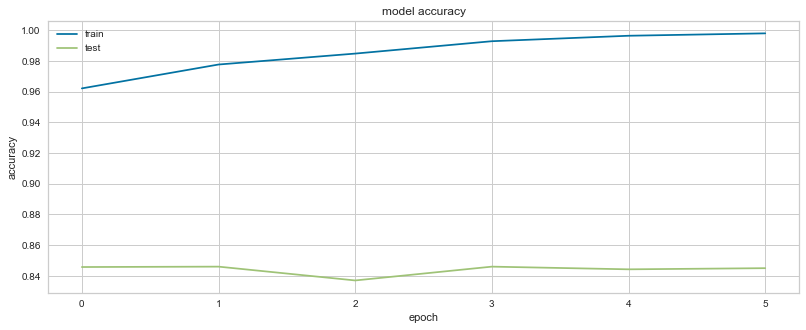

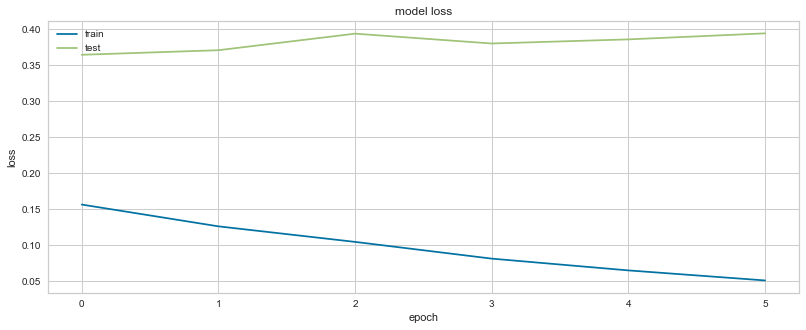

In [98]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In the output, test accuracy is around 83.74% which is good enough. Also, there is a small difference between the training accuracy and test accuracy which means that this model is not overfitting.